# Imports

In [1]:
# data
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# machine learning
import sklearn
from sklearn import metrics, linear_model, svm
import xgboost
import lightgbm

# other
import gc
import json
import tqdm
import itertools
import functools
import random
from numerapi import NumerAPI

# save variables
import pickle
import joblib

# Download data

In [2]:
napi = NumerAPI()
current_round = napi.get_current_round()

# filenames = napi.list_datasets()

napi.download_dataset('v4/live.parquet', f'v4/live_{current_round}.parquet')
napi.download_dataset('v4/live_int8.parquet', f'v4/live_int8_{current_round}.parquet')

2022-07-23 20:47:44,369 INFO numerapi.utils: target file already exists
2022-07-23 20:47:44,372 INFO numerapi.utils: download complete
2022-07-23 20:47:45,378 INFO numerapi.utils: target file already exists
2022-07-23 20:47:45,381 INFO numerapi.utils: download complete


# Dataframes

## Features and columns to read

In [3]:
with open('v4/features.json', 'r') as f:
    feature_metadata = json.load(f)

features_all = list(feature_metadata['feature_stats'].keys())
features_small = feature_metadata['feature_sets']['small']
features_medium = feature_metadata['feature_sets']['medium']
features_v2 = feature_metadata['feature_sets']['v2_equivalent_features']
features_v3 = feature_metadata['feature_sets']['v3_equivalent_features']
features_fncv3 = feature_metadata['feature_sets']['fncv3_features']

features = features_all
target = 'target_nomi_v4_20'

read_columns = ['era', 'data_type'] + features + [target] 

df_feature_metadata = pd.DataFrame(feature_metadata['feature_stats'])
df_feature_metadata

feature_honoured_observational_balaamite  \
legacy_uniqueness                                                         0.177814   
spearman_corr_w_target_nomi_20_mean                                      -0.000796   
spearman_corr_w_target_nomi_20_sharpe                                    -0.078689   
spearman_corr_w_target_nomi_20_reversals                                  0.000074   
spearman_corr_w_target_nomi_20_autocorr                                  -0.013665   
spearman_corr_w_target_nomi_20_arl                                        3.650350   

                                          feature_polaroid_vadose_quinze  \
legacy_uniqueness                                               0.241351   
spearman_corr_w_target_nomi_20_mean                             0.000199   
spearman_corr_w_target_nomi_20_sharpe                           0.020379   
spearman_corr_w_target_nomi_20_reversals                        0.000082   
spearman_corr_w_target_nomi_20_autocorr                         0.110503   
spearman_corr_w_target_nomi_20_arl                              3.456954   

                                          feature_untidy_withdrawn_bargeman  \
legacy_uniqueness                                                  0.659092   
spearman_corr_w_target_nomi_20_mean                               -0.000619   
spearman_corr_w_target_nomi_20_sharpe                             -0.067669   
spearman_corr_w_target_nomi_20_reversals                           0.000067   
spearman_corr_w_target_nomi_20_autocorr                            0.036986   
spearman_corr_w_target_nomi_20_arl                                 2.916201   

                                          feature_genuine_kyphotic_trehala  \
legacy_uniqueness                                                 0.234994   
spearman_corr_w_target_nomi_20_mean                               0.001724   
spearman_corr_w_target_nomi_20_sharpe                             0.127591   
spearman_corr_w_target_nomi_20_reversals                          0.000095   
spearman_corr_w_target_nomi_20_autocorr                           0.149465   
spearman_corr_w_target_nomi_20_arl                                3.984733   

                                          feature_unenthralled_sportful_schoolhouse  \
legacy_uniqueness                                                          0.471051   
spearman_corr_w_target_nomi_20_mean                                        0.000661   
spearman_corr_w_target_nomi_20_sharpe                                      0.065213   
spearman_corr_w_target_nomi_20_reversals                                   0.000072   
spearman_corr_w_target_nomi_20_autocorr                                    0.014508   
spearman_corr_w_target_nomi_20_arl                                         3.702128   

                                          feature_divulsive_explanatory_ideologue  \
legacy_uniqueness                                                        0.608926   
spearman_corr_w_target_nomi_20_mean                                     -0.001529   
spearman_corr_w_target_nomi_20_sharpe                                   -0.173158   
spearman_corr_w_target_nomi_20_reversals                                 0.000058   
spearman_corr_w_target_nomi_20_autocorr                                  0.023341   
spearman_corr_w_target_nomi_20_arl                                       3.411765   

                                          feature_ichthyotic_roofed_yeshiva  \
legacy_uniqueness                                                  0.220884   
spearman_corr_w_target_nomi_20_mean                               -0.000623   
spearman_corr_w_target_nomi_20_sharpe                             -0.084122   
spearman_corr_w_target_nomi_20_reversals                           0.000052   
spearman_corr_w_target_nomi_20_autocorr                           -0.066927   
spearman_corr_w_target_nomi_20_arl                                 3.262500   

                                          fea

## Train

In [4]:
df_train = pd.read_parquet('v4/train_int8.parquet', columns=read_columns)
df_train['era'] = df_train['era'].astype('int32')
df_train.info(memory_usage='deep')
df_train

<class 'pandas.core.frame.DataFrame'>
Index: 2420521 entries, n003bba8a98662e4 to nfff2bd38e397265
Columns: 1194 entries, era to target_nomi_v4_20
dtypes: float32(1), int32(1), int8(1191), object(1)
memory usage: 3.0 GB


era data_type  feature_honoured_observational_balaamite  \
id                                                                          
n003bba8a98662e4    1     train                                         4   
n003bee128c2fcfc    1     train                                         2   
n0048ac83aff7194    1     train                                         2   
n00691bec80d3e02    1     train                                         4   
n00b8720a2fdc4f2    1     train                                         4   
...               ...       ...                                       ...   
nffcc1dbdf2212e6  574     train                                         0   
nffd71b7f6a128df  574     train                                         0   
nffde3b371d67394  574     train                                         1   
nfff1a1111b35e84  574     train                                         4   
nfff2bd38e397265  574     train                                         1   

                  feature_polaroid_vadose_quinze  \
id                                                 
n003bba8a98662e4                               2   
n003bee128c2fcfc                               4   
n0048ac83aff7194                               1   
n00691bec80d3e02                               2   
n00b8720a2fdc4f2                               3   
...                                          ...   
nffcc1dbdf2212e6                               1   
nffd71b7f6a128df                               1   
nffde3b371d67394                               1   
nfff1a1111b35e84                               3   
nfff2bd38e397265                               1   

                  feature_untidy_withdrawn_bargeman  \
id                                                    
n003bba8a98662e4                                  4   
n003bee128c2fcfc                                  1   
n0048ac83aff7194                                  3   
n00691bec80d3e02                                  2   
n00b8720a2fdc4f2                                  4   
...                                             ...   
nffcc1dbdf2212e6                                  0   
nffd71b7f6a128df                                  0   
nffde3b371d67394                                  2   
nfff1a1111b35e84                                  2   
nfff2bd38e397265                                  3   

                  feature_genuine_kyphotic_trehala  \
id                                                   
n003bba8a98662e4                                 4   
n003bee128c2fcfc                                 3   
n0048ac83aff7194                                 0   
n00691bec80d3e02                                 3   
n00b8720a2fdc4f2                                 4   
...                                            ...   
nffcc1dbdf2212e6                                 1   
nffd71b7f6a128df                                 4   
nffde3b371d67394                                 1   
nfff1a1111b35e84                                 2   
nfff2bd38e397265                                 0   

                  feature_unenthralled_sportful_schoolhouse  \
id                                                            
n003bba8a98662e4                                          0   
n003bee128c2fcfc                                          0   
n0048ac83aff7194                                          3   
n00691bec80d3e02                                          0   
n00b8720a2fdc4f2                                          0   
...                                                     ...   
nffcc1dbdf2212e6                                          4   
nffd71b7f6a128df                                          2   
nffde3b371d67394                                          3   
nfff1a1111b35e84                                          3   
nfff2bd38e397265                                          2   

                  feature_divulsive_explanatory_ideologue  \
id                                     

## Validation + Test

In [5]:
# df_validation = pd.read_parquet('v4/validation_int8.parquet', columns=read_columns)
# df_validation['era'] = df_validation['era'].astype('int32')
# df_validation.info(memory_usage='deep')
# df_validation

In [6]:
# df_test = df_validation.loc[df_validation['data_type'] == 'test']
# df_test.info(memory_usage='deep')
# df_test

## Live

In [7]:
# df_live = pd.read_parquet('v4/live_int8.parquet', columns=read_columns)
# df_live.info(memory_usage='deep')
# df_live

# Analyse data

## Number of examples as a function of the era

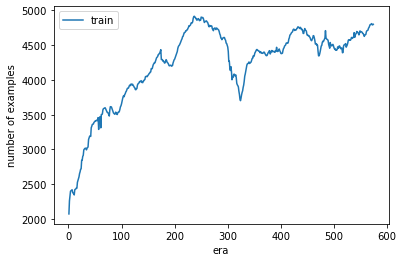

In [8]:
x_train = df_train.groupby('era').size().index.values
y_train = df_train.groupby('era').size().values
# x_validation = df_validation[df_validation.data_type == 'validation'].groupby('era').size().index.values
# y_validation = df_validation[df_validation.data_type == 'validation'].groupby('era').size().values
# x_test = df_validation[df_validation.data_type == 'test'].groupby('era').size().index.values
# y_test = df_validation[df_validation.data_type == 'test'].groupby('era').size().values

fig, ax = plt.subplots()
ax.plot(x_train, y_train, label='train')
# ax.plot(x_validation, y_validation, label='validation')
# ax.plot(x_test, y_test, label='test')
ax.set_xlabel('era')
ax.set_ylabel('number of examples')
ax.legend()

## Feature correlation heatmap

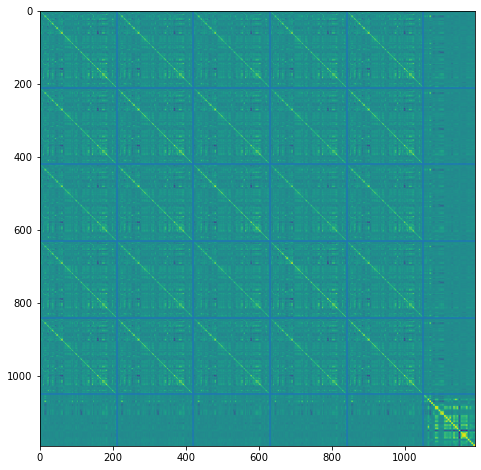

In [9]:
feature_correlations = df_train[df_train.era==1][features].corr()
plt.figure(figsize = (8,8))
plt.imshow(feature_correlations)
for a in [210, 420, 630, 840, 1050]:
    plt.axvline(a)
    plt.axhline(a)

feature_groups = [features[0:210],
                  features[210:420],
                  features[420:630],
                  features[840:1050],
                  features[1050:-1]]

## Correlation of feature with target as a function of the era

In [10]:
eras_train = df_train.era.unique()
# target_correlations = np.array([np.corrcoef(df_train[df_train.era == e][[target] + features].T)[0, 1:] for e in eras_train])
# target_correlations = pd.DataFrame(target_correlations)
# target_correlations.rename(columns = dict(enumerate(features)), inplace = True)
# target_correlations.insert(0, 'era', eras_train)
# joblib.dump(target_correlations, 'saved-variables/target_correlations.pkl')
target_correlations = joblib.load('saved-variables/target_correlations.pkl')

Text(0, 0.5, 'correlation with target')

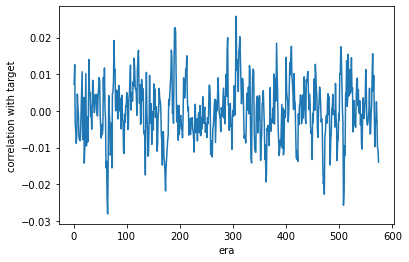

In [11]:
x = target_correlations['era']
y = target_correlations['feature_untidy_withdrawn_bargeman']

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel('era')
ax.set_ylabel('correlation with target')

# Test models

In this section we test many models without caring about hyperparameters (i.e., just use the defaults for each model). The goal is to identify which models look the most promising. We want to consider the time to train, as well as

Performance metrics:

- correlation
- rank-correlation / spearman-correlation
- `sklearn.metrics.r2_score`
- `sklearn.metrics.mean_squared_error`

Models worth trying at first

- `sklearn.linear_model.LinearRegression()`
- `sklearn.linear_model.LogisticRegression()`
- `sklearn.linear_model.SGDRegressor()` (Stochastic Gradient Descent regressor)
- `sklearn.linear_model.Lasso()`
- `sklearn.linear_model.ElasticNet()`
- `sklearn.linear_model.Ridge()`
- `sklearn.svm.SVR(kernel='rbf')` (Support Vector Machine / Regression)
- `sklearn.svm.SVR(kernel='linear')`
- `lightgbm.LGBMRegressor()`
- `xgboost.XGBRegressor()`

In [15]:
X = df_train[df_train.era.isin(np.arange(1, 547, 4))][features]
y = df_train[df_train.era.isin(np.arange(1, 547, 4))][target]

In [19]:
model_lin = linear_model.LinearRegression(copy_X = False)
model_lin.fit(X, y)
print(model_lin.score(X, y))

MemoryError: Unable to allocate 5.09 GiB for an array with shape (573127, 1191) and data type float64